# Project Assignment:  Amazon products dataset

## Students

* Team: `9`
* Students: `Mateja Ilić & Miloš Novaković` (for the team submission)

## Part 1: Dataset exploration

The main goal of our project is to perform a graph classification task on the Amazon Products dataset. However, for a better understanding of the dataset, what it represents and what we can do with it, it is always useful to use the various tools we have from graph theory and network science to explore the network underlying our data.

The Amazon Products dataset is a projection of a bipartite graph, whose one part contains nodes that represent users and whose other part contains products. The users and products are connected with an edge, if the user bought the product. The projection of this graph on the product part gives us a graph of 1,569,960 nodes, that are connected with 264,339,468 edges. In other words, two nodes are connected if users that bought one, also bought the other.

Each product node also comes with a feature vector $x\in\mathbb{R}^{200}$, which is an SVM-reduced vector of a much larger vector of 4-gram word counts from the reviews of the product. Each nodes is also labeled with zero or more of the 107 product category labels. A training, testing and validation mask is provided to divide up the node feature and label data when training and testing our models.

This part of the project will focus more on the underlying network, than on the provided node features and labels.

In [1]:
# downloading the necessary packages
!pip install torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html


In [2]:
# importing the necessary packages and classes
import networkx as nx
from torch import nn
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.datasets import AmazonProducts
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# upload your code to your Google Drive to import the data automatically
from google.colab import drive
drive.mount('/content/drive')
data_folder_path = '/content/drive/MyDrive/data/NML_Final_Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# we load the data set
dataset = AmazonProducts(root=data_folder_path)
# in this case, we save only the edge index to save on space
edge_index = dataset[0].edge_index.numpy()
del dataset
print(edge_index)

tensor([[      0,       0,       0,  ..., 1569958, 1569959, 1569959],
        [      0,   83053,  210735,  ..., 1569958, 1178338, 1569959]])


## Global graph properties

To start, let's load our graph into networkX.

In [9]:
# we implement a custom class to further reduce the memory footprint of the networkX graph
class ThinGraph(nx.Graph):
    all_edge_dict = {"weight": 1}

    def single_edge_dict(self):
        return self.all_edge_dict

    edge_attr_dict_factory = single_edge_dict

G = ThinGraph()
for e in range(edge_index.shape[1]):
  G.add_edge(edge_index[0,e], edge_index[1,e])

### Basic graph properties:

In [10]:
print('Number of nodes: {}, Number of edges: {}'. format(G.number_of_nodes(), G.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(G), nx.number_connected_components(G)))

Number of nodes: 1569960, Number of edges: 132954714
Number of self-loops: 1569960, Number of connected components: 492143


We instatiated our Graph object as an instance of a regular graph subclass, instead of a digraph, because it is easier to manipulate. This is somewhat of an approximation, as we can see that our number of edges is slightly higher than 50% of the original number of edges in `edge_index`. However, working the numbers out shows that only around 0.29% of edges weren't bi-directional, so we consider the approximation to be appropriate in this case.

### Sparsity:

In [12]:
print('Graph average degree: {}'. format(2*G.number_of_edges()/G.number_of_nodes()))

Graph average degree: 169.37337766567302


As we can see, the average degree of our graph is 4 orders of magnitude smaller than the number of nodes in the graph, i.e. $<k>\ll N$. From this we can say with confidence that our graph is sparse.

### Giant component:

Since we have a lot of connected components in our graph, let's check out the scale of the largest one to get a further feel for the type of network we are working with:

In [13]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len)) # Your code here.
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_component.number_of_nodes(), giant_component.size()))

The giant component of the citation graph has 1066627 nodes and 132430138 edges.


The giant component contains ~67.94% of the nodes but ~99.6% of the edges. This means that most of the other components basically just consist of isolated nodes. In the context of our dataset, these nodes represent products for which there was not enough data to link with other products.

Let's check the diameter of the giant component:

In [15]:
print('Diameter of the giant component: {}'.format(nx.algorithms.approximation.distance_measures.diameter(giant_component)))

Diameter of the giant component: 19


Since the giant component subgraph was too big for a brute force diameter computation, we decided to use an [approximate procedure](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.distance_measures.diameter.html#r1a85b65cb0d3-1) that computes a lower bound on the (sub)graph diameter. We can see that, compared to its size, the giant component is fairly well connected, having a lower bound diameter of just 19. Since our graph is sparse, that means that our graph propably contains some large hubs through which many of the shortest paths go through.

### Degree distribution:

The above calculations gave us some indication about the type of network we are dealing with. To elucidate this even better, let's take a look at the degree distribution ouf our graph:

In [18]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
print('The top 10 hubs have degrees of: {}'.format(degree_sequence[:10]))

The top 10 hubs have degrees of: [75135, 62409, 53409, 52950, 49801, 49446, 49384, 46101, 44767, 44677]


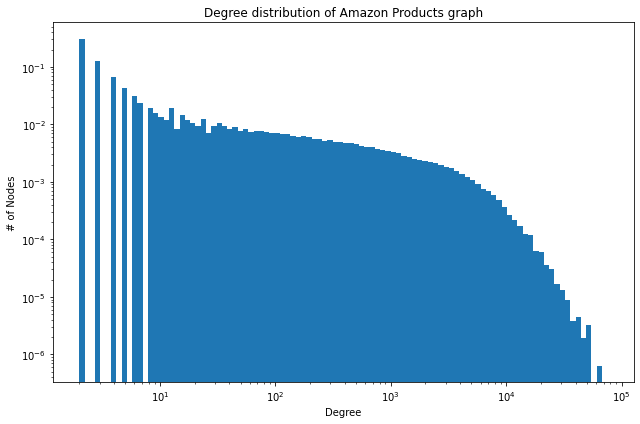

In [51]:
_, bins = np.histogram(np.log10(degree_sequence), bins=100)
fig = plt.figure(figsize=(9, 6))
ax0 = fig.add_subplot()
deg_hist_normalization = np.ones(1569960) / 1569960
ax0.hist(degree_sequence, log=True, bins=10**bins, weights=deg_hist_normalization)
plt.gca().set_xscale("log")
ax0.set_title('Degree distribution of Amazon Products graph')
ax0.set_xlabel("Degree")
ax0.set_ylabel("# of Nodes")
fig.tight_layout()

From the histogram we can see that the degree distribution is closer to an exponential-type distribution than a power-law distribution. Most of the nodes have very low degrees, even lower than $<k>$, while only a very small proportion of nodes have very high degrees. However, the exponential drop in high degree node frequency is much less steep than what we're used to when modeling high node count random networks with a Poisson distribution.

In other words, our network doesn't fit well with either the random network or the scale-free network model family.

## Label distribution

In order to get a grasp on the classification task itself, it is useful to check out the label distribution. We will see how to handle multi-class, multi-label exlporation problems in the exploitation part of the project.

In [53]:
# we reload the data set to explore the labels
dataset = AmazonProducts(root=data_folder_path)
y = dataset[0].y.numpy()
del dataset

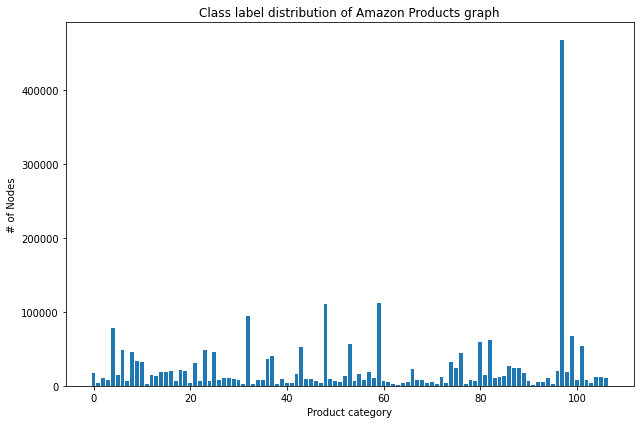

In [56]:
fig = plt.figure(figsize=(9, 6))
ax0 = fig.add_subplot()
ax0.bar([i for i in range(107)], y.sum(axis=0))
ax0.set_title('Class label distribution of Amazon Products graph')
ax0.set_xlabel("Product category")
ax0.set_ylabel("# of Nodes")
fig.tight_layout()